# Autoclarity — Deep Neural Networks Project


## Imports & Setup


In [ ]:
from torchinfo import summary
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# import wandb
# os.environ["WANDB_NOTEBOOK_NAME"] = "autoclarity.ipynb"
# wandb.init(project="autoclarity", entity="jpranaymartin")

wandb: Currently logged in as: jpranaymartin. Use `wandb login --relogin` to force relogin


## Hyperparameters

In [ ]:
# Device to translate tensors to:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

# Configuration:
batch_size = 64
num_epochs = 10
learning_rate = 0.001

wandb.config.batch_size = batch_size


## Data Loading


In [ ]:
# Transforms
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Datasets
train_dataset = torchvision.datasets.MNIST(
    root="./downloads", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./downloads", train=False, transform=transform, download=True
)

# Data-loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

### Noising Function


In [ ]:
# Adding noise to the dataset
def add_noise(img, noise_factor=0.2):
    noise = torch.randn(img.size()).to(device) * noise_factor
    noisy_img = img + noise
    return noisy_img

## Model Definition


### Model 1 - Linear Layers (MLP)


In [ ]:
# Linear-Linear-Tanh Autoencoder
class Autoencoder_FC(nn.Module):
    def __init__(self):
        super(Autoencoder_FC, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


mlp_model = Autoencoder_FC().to(device)

In [ ]:
# Use torchinfo summary to get model summary
summary(mlp_model, input_size=(batch_size, 28 * 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_FC                           [64, 784]                 --
├─Sequential: 1-1                        [64, 12]                  --
│    └─Linear: 2-1                       [64, 128]                 100,480
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 64]                  8,256
│    └─ReLU: 2-4                         [64, 64]                  --
│    └─Linear: 2-5                       [64, 12]                  780
├─Sequential: 1-2                        [64, 784]                 --
│    └─Linear: 2-6                       [64, 64]                  832
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 128]                 8,320
│    └─ReLU: 2-9                         [64, 128]                 --
│    └─Linear: 2-10                      [64, 784]                 101,1

### Model 2 - Convolutional Layers (CNN)


In [ ]:
# # Conv-ConvTranspose Autoencoder
# class Autoencoder_CNN(nn.Module):
#     def __init__(self):
#         super(Autoencoder_CNN, self).__init__()
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.Conv2d(16, 8, kernel_size=3)  # Compressed representation
#         )
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, kernel_size=3),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         x = x.view(-1, 1, 28, 28)  # Reshape input to (Batch_size, Channels, Height, Width)
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x.view(x.size(0), -1)  # Reshape back to (Batch_size, 784)


# cnn_model = Autoencoder_CNN().to(device)

In [ ]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super(Autoencoder_CNN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(
                16, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(
                32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(
            -1, 1, 28, 28
        )  # Reshape input to (Batch_size, Channels, Height, Width)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(x.size(0), -1)  # Reshape back to (Batch_size, 784)


# Instantiate the model and define the optimizer and loss function
cnn_model = Autoencoder_CNN().to(device)

In [ ]:
# Use torchinfo summary to get model summary
summary(cnn_model, input_size=(batch_size, 28 * 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_CNN                          [64, 784]                 --
├─Sequential: 1-1                        [64, 8, 5, 5]             --
│    └─Conv2d: 2-1                       [64, 32, 14, 14]          320
│    └─LeakyReLU: 2-2                    [64, 32, 14, 14]          --
│    └─Conv2d: 2-3                       [64, 16, 7, 7]            4,624
│    └─LeakyReLU: 2-4                    [64, 16, 7, 7]            --
│    └─Conv2d: 2-5                       [64, 8, 5, 5]             1,160
│    └─LeakyReLU: 2-6                    [64, 8, 5, 5]             --
├─Sequential: 1-2                        [64, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-7              [64, 16, 7, 7]            1,168
│    └─LeakyReLU: 2-8                    [64, 16, 7, 7]            --
│    └─ConvTranspose2d: 2-9              [64, 32, 14, 14]          4,640
│    └─LeakyReLU: 2-10                   [64, 32, 14, 14]          --
│ 

In [ ]:
# Instantiate models and optimizers
models = {
    "mlp_model": mlp_model, 
    "mlp_model_optimizer": torch.optim.Adam(
        mlp_model.parameters(), lr=learning_rate
    ),
    "cnn_model": cnn_model,
    "cnn_model_optimizer": torch.optim.Adam(
        cnn_model.parameters(), lr=learning_rate
    )
}

## Training Loop


### Loss Function


In [ ]:
criterion = nn.SmoothL1Loss()

### Training


Epoch [1/10], Loss: 0.0543
mlp_model Validation Loss: 0.0490
Epoch [2/10], Loss: 0.0374
mlp_model Validation Loss: 0.0410
Epoch [3/10], Loss: 0.0437
mlp_model Validation Loss: 0.0371
Epoch [4/10], Loss: 0.0310
mlp_model Validation Loss: 0.0350
Epoch [5/10], Loss: 0.0366
mlp_model Validation Loss: 0.0339
Epoch [6/10], Loss: 0.0365
mlp_model Validation Loss: 0.0323
Epoch [7/10], Loss: 0.0300
mlp_model Validation Loss: 0.0316
Epoch [8/10], Loss: 0.0301
mlp_model Validation Loss: 0.0310
Epoch [9/10], Loss: 0.0266
mlp_model Validation Loss: 0.0303
Epoch [10/10], Loss: 0.0295
mlp_model Validation Loss: 0.0300


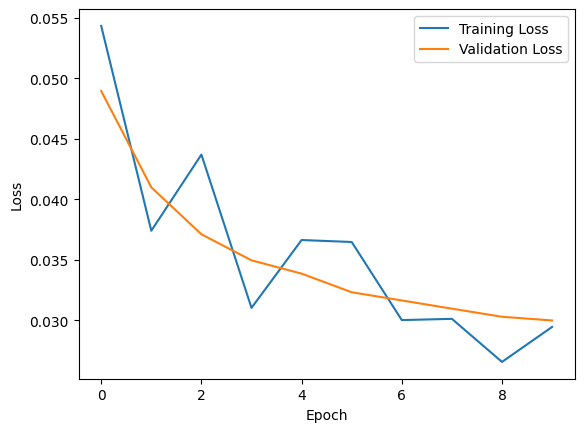

Epoch [1/10], Loss: 0.0083
cnn_model Validation Loss: 0.0086
Epoch [2/10], Loss: 0.0065
cnn_model Validation Loss: 0.0063
Epoch [3/10], Loss: 0.0048
cnn_model Validation Loss: 0.0057
Epoch [4/10], Loss: 0.0051
cnn_model Validation Loss: 0.0050
Epoch [5/10], Loss: 0.0045
cnn_model Validation Loss: 0.0046
Epoch [6/10], Loss: 0.0051
cnn_model Validation Loss: 0.0045
Epoch [7/10], Loss: 0.0047
cnn_model Validation Loss: 0.0043
Epoch [8/10], Loss: 0.0038
cnn_model Validation Loss: 0.0042
Epoch [9/10], Loss: 0.0045
cnn_model Validation Loss: 0.0041
Epoch [10/10], Loss: 0.0037
cnn_model Validation Loss: 0.0040


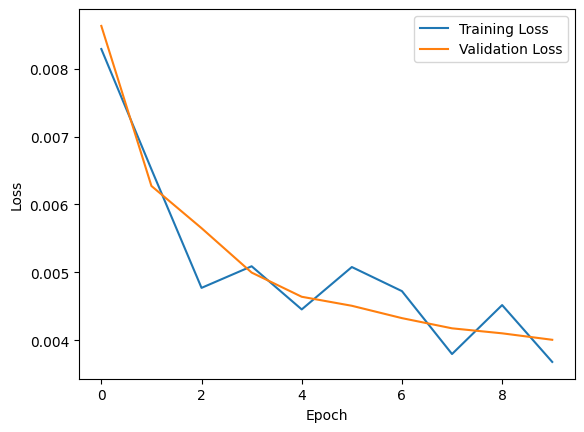

In [ ]:
model_names = ["mlp_model", "cnn_model"]

for model_name in model_names:

    model = models[model_name]
    optimizer = models[f"{model_name}_optimizer"]

    epoch_losses = []
    validation_losses = []

    # if model_name == "mlp_model":
        # wandb.watch(model, log_freq=100)

    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)

            # Forward pass
            outputs = model(noisy_img)
            loss = criterion(outputs, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # Calculate validation loss
        validation_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                img, _ = data
                img = img.view(img.size(0), -1).to(device)
                noisy_img = add_noise(img)
                outputs = model(noisy_img)
                loss = criterion(outputs, img)
                validation_loss += loss.item()

        validation_loss /= len(test_loader)
        validation_losses.append(validation_loss)
        print(f"{model_name} Validation Loss: {validation_loss:.4f}")

        wandb.log({f"{model_name}_train_loss": loss.item()})
        wandb.log({f"{model_name}_val_loss": validation_loss})

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Testing Loop


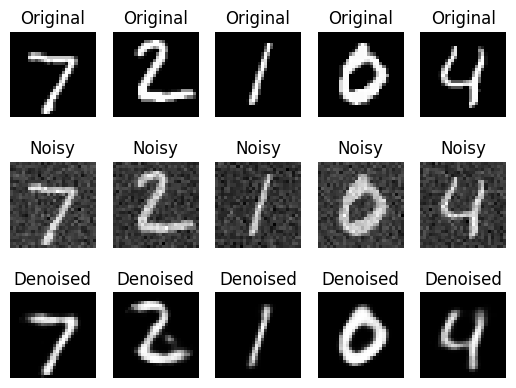

mlp_model Test Loss: 0.0002


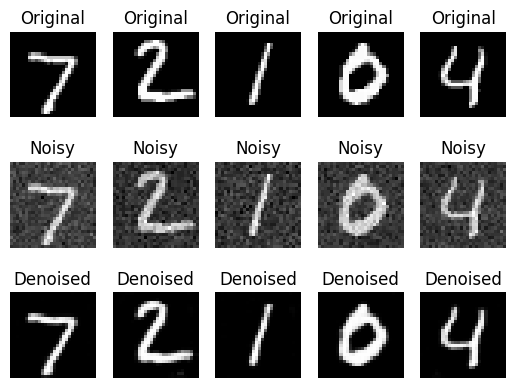

cnn_model Test Loss: 0.0000


In [ ]:
for model_name in model_names:
    model = models[model_name]

    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)
            outputs = model(noisy_img)

            loss = criterion(outputs, img)
            test_loss += loss.item()

            # Visualize the first 5 images
            for i in range(5):
                plt.subplot(3, 5, i + 1)
                plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Original")
                plt.axis("off")

                plt.subplot(3, 5, i + 6)
                plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Noisy")
                plt.axis("off")

                plt.subplot(3, 5, i + 11)
                plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Denoised")
                plt.axis("off")
            plt.show()
            break

        test_loss /= len(test_loader)   
        print(f"{model_name} Test Loss: {test_loss:.4f}")

## Experiment: Batch normalization

Epoch [1/10], Loss: 0.0248
bn_model Validation Loss: 0.0068
Epoch [2/10], Loss: 0.0063
bn_model Validation Loss: 0.0054
Epoch [3/10], Loss: 0.0053
bn_model Validation Loss: 0.0048
Epoch [4/10], Loss: 0.0048
bn_model Validation Loss: 0.0049
Epoch [5/10], Loss: 0.0045
bn_model Validation Loss: 0.0042
Epoch [6/10], Loss: 0.0044
bn_model Validation Loss: 0.0042
Epoch [7/10], Loss: 0.0042
bn_model Validation Loss: 0.0039
Epoch [8/10], Loss: 0.0041
bn_model Validation Loss: 0.0037
Epoch [9/10], Loss: 0.0040
bn_model Validation Loss: 0.0037
Epoch [10/10], Loss: 0.0039
bn_model Validation Loss: 0.0036


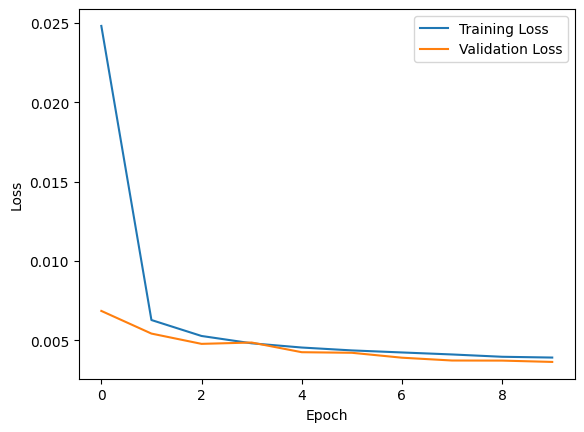

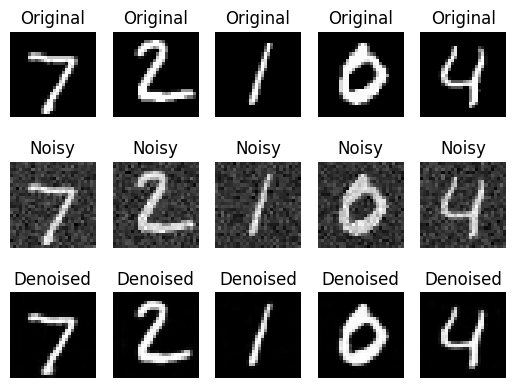

bn_model Test Loss: 0.0000


In [ ]:
# # Conv-ConvTranspose Autoencoder
class AutoencoderBN(nn.Module):
    def __init__(self):
        super(AutoencoderBN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(8),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(
                16, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(
                32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape input to (Batch_size, Channels, Height, Width)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(x.size(0), -1)  # Reshape back to (Batch_size, 784)


bn_model = AutoencoderBN().to(device)

# Use torchinfo summary to get model summary
summary(bn_model, input_size=(batch_size, 28 * 28), device=device)

optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)

epoch_losses = []
validation_losses = []

for epoch in range(num_epochs):
    bn_model.train()
    total_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        # Forward pass
        outputs = bn_model(noisy_img)
        loss = criterion(outputs, img)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Calculate validation loss
    bn_model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)
            outputs = bn_model(noisy_img)
            loss = criterion(outputs, img)
            validation_loss += loss.item()

    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)
    print(f"bn_model Validation Loss: {validation_loss:.4f}")

plt.figure()
plt.plot(epoch_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss = 0.0

bn_model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        outputs = bn_model(noisy_img)

        loss = criterion(outputs, img)
        test_loss += loss.item()

        # Visualize the first 5 images
        for i in range(5):
            plt.subplot(3, 5, i + 1)
            plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Noisy")
            plt.axis("off")

            plt.subplot(3, 5, i + 11)
            plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Denoised")
            plt.axis("off")
        plt.show()
        break

    test_loss /= len(test_loader)   
    print(f"bn_model Test Loss: {test_loss:.4f}")

## Single-Convolution?

In [ ]:
class MiniDenoiser(nn.Module):
    def __init__(self):
        super(MiniDenoiser, self).__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)
    
mini_model = MiniDenoiser().to(device)
print(summary(mini_model, input_size=(batch_size, 1, 28, 28), device=device))

Layer (type:depth-idx)                   Output Shape              Param #
MiniDenoiser                             [64, 1, 28, 28]           --
├─Conv2d: 1-1                            [64, 1, 28, 28]           10
Total params: 10
Trainable params: 10
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.50
Input size (MB): 0.20
Forward/backward pass size (MB): 0.40
Params size (MB): 0.00
Estimated Total Size (MB): 0.60


Epoch [1/10], Loss: 0.0375
mini_model Validation Loss: 0.0305
Epoch [2/10], Loss: 0.0125
mini_model Validation Loss: 0.0335
Epoch [3/10], Loss: 0.0114
mini_model Validation Loss: 0.0350
Epoch [4/10], Loss: 0.0113
mini_model Validation Loss: 0.0353
Epoch [5/10], Loss: 0.0113
mini_model Validation Loss: 0.0353
Epoch [6/10], Loss: 0.0114
mini_model Validation Loss: 0.0352
Epoch [7/10], Loss: 0.0113
mini_model Validation Loss: 0.0352
Epoch [8/10], Loss: 0.0113
mini_model Validation Loss: 0.0352
Epoch [9/10], Loss: 0.0113
mini_model Validation Loss: 0.0352
Epoch [10/10], Loss: 0.0114
mini_model Validation Loss: 0.0353


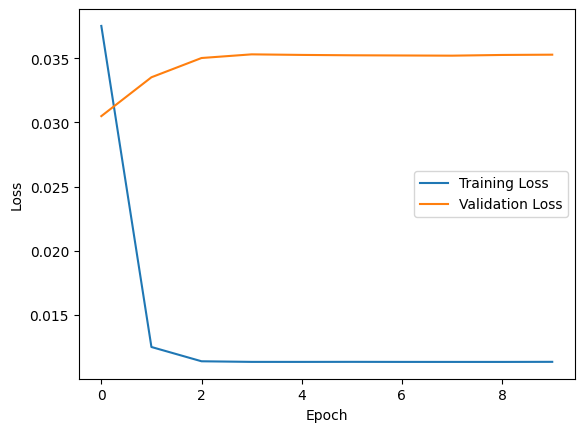

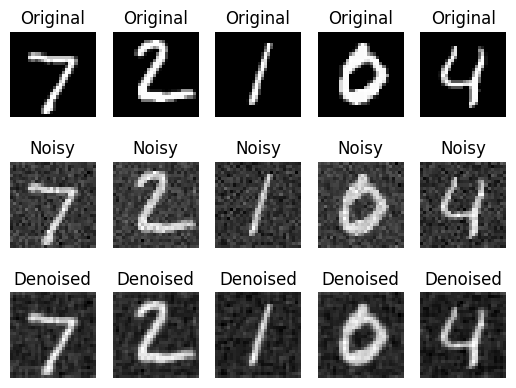

mini_model Test Loss: 0.0001


In [ ]:
mini_model_optimizer = torch.optim.Adam(mini_model.parameters(), lr=0.001)

epoch_losses = []
validation_losses = []

for epoch in range(num_epochs):
    mini_model.train()
    total_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        noisy_img = add_noise(img)
        # Forward pass
        outputs = mini_model(noisy_img)
        loss = criterion(outputs, img)
        # Backward and optimize
        mini_model_optimizer.zero_grad()
        loss.backward()
        mini_model_optimizer.step()
        total_loss += loss.item()

    avg_epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Calculate validation loss
    mini_model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.to(device)
            noisy_img = add_noise(img,noise_factor=0.4)
            outputs = mini_model(noisy_img)
            loss = criterion(outputs, img)
            validation_loss += loss.item()

    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)
    print(f"mini_model Validation Loss: {validation_loss:.4f}")

plt.figure()
plt.plot(epoch_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss = 0.0

mini_model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        noisy_img = add_noise(img, )
        outputs = mini_model(noisy_img)

        loss = criterion(outputs, img)
        test_loss += loss.item()

        # Visualize the first 5 images
        for i in range(5):
            plt.subplot(3, 5, i + 1)
            plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Noisy")
            plt.axis("off")

            plt.subplot(3, 5, i + 11)
            plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Denoised")
            plt.axis("off")
        plt.show()
        break

    test_loss /= len(test_loader)   
    print(f"mini_model Test Loss: {test_loss:.4f}")
